# Genesis4 Class

In [1]:
# Useful for debugging
%load_ext autoreload
%autoreload 2

In [2]:
from genesis.version4 import Genesis4

Instantiate the object on a value init file. This will configure a working directory that stages all input and output files.

In [3]:
FILE = 'data/basic4/cu_hxr.in'

G = Genesis4(FILE, verbose = True)

Configured to run in: /var/folders/2f/l5_mybzs30j4qqvyj98w1_nw0000gn/T/tmpaycygf2l


Input is simply a list of dicts corresponding to the namelist

In [4]:
G.input

{'main': [{'type': 'setup',
   'rootname': 'LCLS2_HXR_9keV',
   'lattice': '/Users/chrisonian/Code/GitHub/lume-genesis/docs/examples/genesis4/data/basic4/hxr.lat',
   'beamline': 'HXR',
   'lambda0': 1.3789244869952112e-10,
   'gamma0': 19174.0776,
   'delz': 0.026,
   'seed': 84672,
   'npart': 1024},
  {'type': 'time', 'slen': 1.5e-05, 'sample': 200},
  {'type': 'field', 'dgrid': 0.0001, 'ngrid': 101, 'accumulate': True},
  {'type': 'profile_file',
   'label': 'beamcurrent',
   'xdata': array([0.00000000e+00, 7.50037502e-10, 1.50007500e-09, ...,
          1.49984999e-05, 1.49992500e-05, 1.50000000e-05]),
   'ydata': array([2.65147892, 2.65521019, 2.65894633, ..., 2.65894633, 2.65521019,
          2.65147892])},
  {'type': 'profile_file',
   'label': 'beamgamma',
   'xdata': array([0.00000000e+00, 7.50037502e-10, 1.50007500e-09, ...,
          1.49984999e-05, 1.49992500e-05, 1.50000000e-05]),
   'ydata': array([19394.23415577, 19394.21213902, 19394.19012226, ...,
          18953.96507

Change something

In [5]:
G.input['main'][-1]['zstop'] = 10
G.input['main'][-1][ 'field_dump_at_undexit'] = True

In [6]:
# Add writing a field file
G.input['main'].append({'type':'write', 'field':'end'})

Run with MPI

In [7]:
G.nproc = 8
G.run()

Setting use_mpi = True because nproc = 8
Running Genesis4 in /var/folders/2f/l5_mybzs30j4qqvyj98w1_nw0000gn/T/tmpaycygf2l
/opt/local/bin/mpirun -n 8 /Users/chrisonian/Code/GitHub/Genesis-1.3-Version4/build/genesis4 genesis4.in
---------------------------------------------
GENESIS - Version 4.6.2 (beta) has started...
Compile info: Compiled by chrisonian at 2023-02-16 20:48:14 [UTC] from Git Commit ID: babc4431d0aba1ecdad371816418713fdff0af53
Starting Time: Sun Feb 19 16:25:57 2023

MPI-Comm Size: 8 nodes

Parsing lattice file...
Setting up time window of 15.0027 microns with 544 sample points...
Generating input radiation field for HARM = 1 ...
Adding profile with label: beamcurrent
Adding profile with label: beamgamma
Generating input particle distribution...

Running Core Simulation...
Time-dependent run with 544 slices for a time window of 15.0027 microns
Initial analysis of electron beam and radiation field...
  Calculation: 10% done
  Calculation: 20% done
  Calculation: 30% done


## Output

The main output is an HDF5. The Genesis4 object loads this data into a flat dict

In [8]:
G.load_output()

In [9]:
G.output.keys()

dict_keys(['run_info', 'outfile', 'field_files', 'field', 'Beam/LSCfield', 'Beam/alphax', 'Beam/alphay', 'Beam/betax', 'Beam/betay', 'Beam/bunching', 'Beam/bunchingphase', 'Beam/current', 'Beam/efield', 'Beam/emitx', 'Beam/emity', 'Beam/energy', 'Beam/energyspread', 'Beam/pxposition', 'Beam/pyposition', 'Beam/wakefield', 'Beam/xposition', 'Beam/xsize', 'Beam/yposition', 'Beam/ysize', 'Field/dgrid', 'Field/intensity-farfield', 'Field/intensity-nearfield', 'Field/ngrid', 'Field/phase-farfield', 'Field/phase-nearfield', 'Field/power', 'Field/xposition', 'Field/xsize', 'Field/yposition', 'Field/ysize', 'Global/frequency', 'Global/gamma0', 'Global/lambdaref', 'Global/one4one', 'Global/s', 'Global/sample', 'Global/scan', 'Global/slen', 'Global/time', 'Lattice/aw', 'Lattice/ax', 'Lattice/ay', 'Lattice/chic_angle', 'Lattice/chic_lb', 'Lattice/chic_ld', 'Lattice/chic_lt', 'Lattice/cx', 'Lattice/cy', 'Lattice/dz', 'Lattice/gradx', 'Lattice/grady', 'Lattice/ku', 'Lattice/kx', 'Lattice/ky', 'Latti

In [10]:
G.output['outfile']

'/var/folders/2f/l5_mybzs30j4qqvyj98w1_nw0000gn/T/tmpaycygf2l/LCLS2_HXR_9keV.out.h5'

## Fields

Field files can be very large and are not loaded by default. Instead, the files found are collected as a list:

In [11]:
G.output['field_files']

['/var/folders/2f/l5_mybzs30j4qqvyj98w1_nw0000gn/T/tmpaycygf2l/end.fld.h5']

This will load all files in the list

In [12]:
G.load_field_files()

Loaded field data: end


In [13]:
G.output['field'].keys()

dict_keys(['end'])

This field data has two parts: basic parameters `param`, and the raw 3D complex array `dfl`:

In [14]:
G.output['field']['end']['param']

{'gridpoints': 101,
 'gridsize': 2e-06,
 'refposition': 0.0,
 'wavelength': 1.3789244869952112e-10,
 'slicecount': 544,
 'slicespacing': 2.7578489739904225e-08}

In [15]:
G.output['field']['end']['dfl'].shape

(101, 101, 544)

`.field` is a convenience property that points to this

In [16]:
G.field.keys()

dict_keys(['end'])

## Visualize Field

In [17]:
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

In [18]:
# Sum over y and compute the absolute square 
dfl = G.field['end']['dfl']
param = G.field['end']['param']
dat2 = np.abs(np.sum(dfl, axis=1))**2

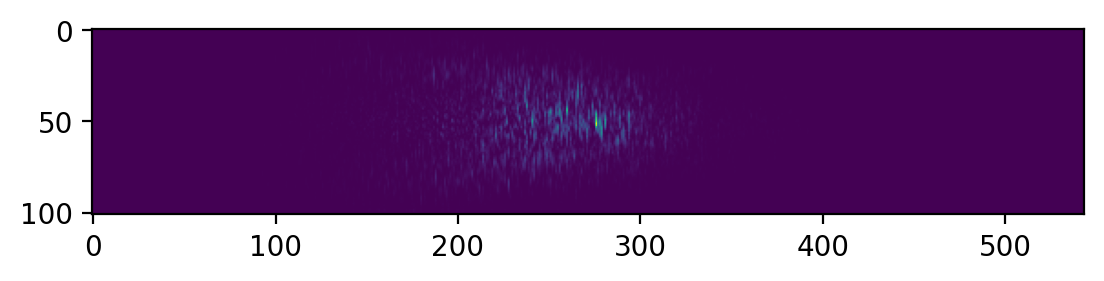

In [19]:
plt.imshow(dat2)

In [20]:
param

{'gridpoints': 101,
 'gridsize': 2e-06,
 'refposition': 0.0,
 'wavelength': 1.3789244869952112e-10,
 'slicecount': 544,
 'slicespacing': 2.7578489739904225e-08}

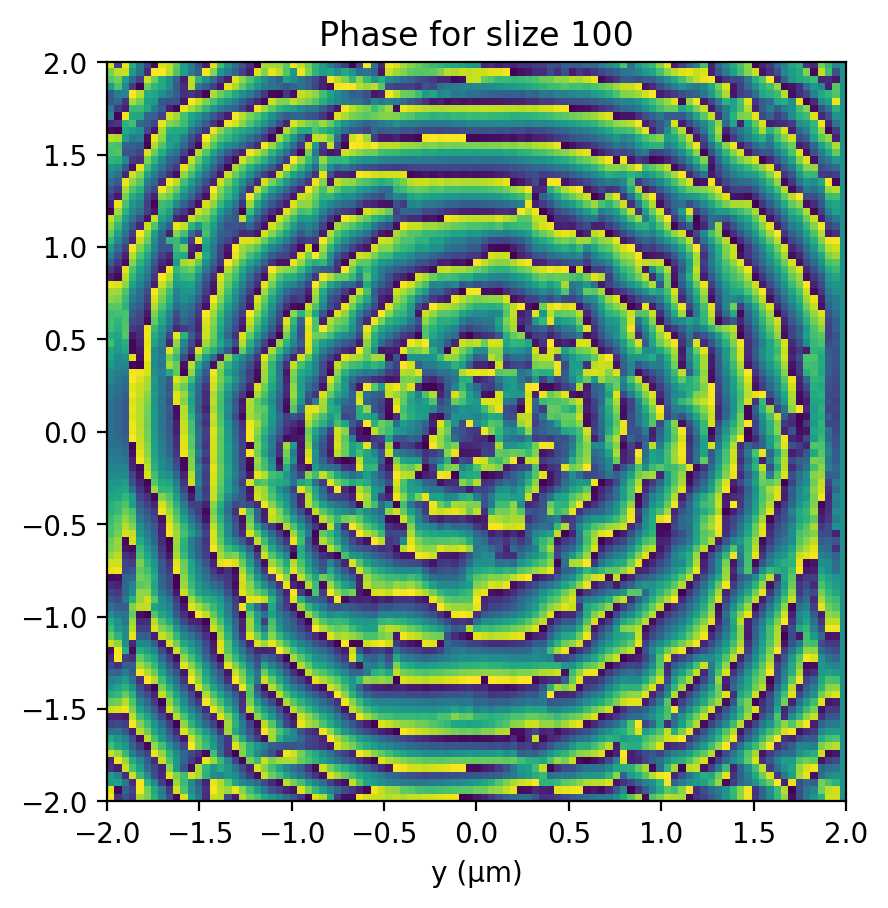

In [21]:
def plot_slice(i=0):
    
    dat = np.angle(dfl[:,:,i])
    
    dx = param['gridsize']*1e6
    plt.xlabel('x (µm)')
    plt.xlabel('y (µm)')
    plt.title(f'Phase for slize {i}')
    plt.imshow(dat.T, origin='lower', extent=[-dx,dx,-dx,dx])
plot_slice(i=100)

## Units

Each item in the output dict has a corresponding units

In [22]:
G.units('Beam/betax')

pmd_unit('m', 1, (1, 0, 0, 0, 0, 0, 0))

## Archiving

In [23]:
afile = G.archive()

Archiving to file genesis4_a941f28d0b3aa68307d10d3895aedef1.h5


In [24]:
# This is not yet implemented
try:
    G.from_archive(afile)
except NotImplementedError:
    print('from_archive is not implemented')

from_archive is not implemented


In [25]:
G.load_output()

# Plotting

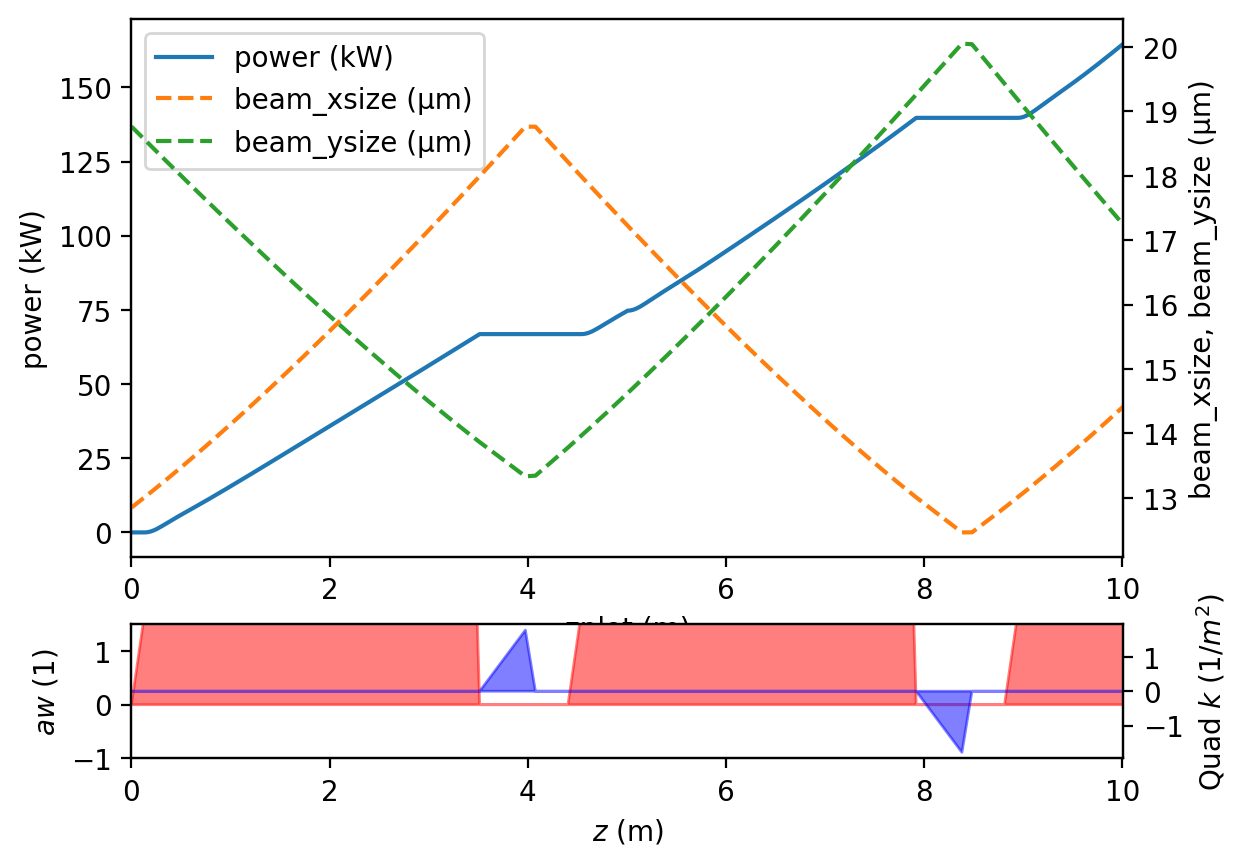

In [26]:
G.plot()

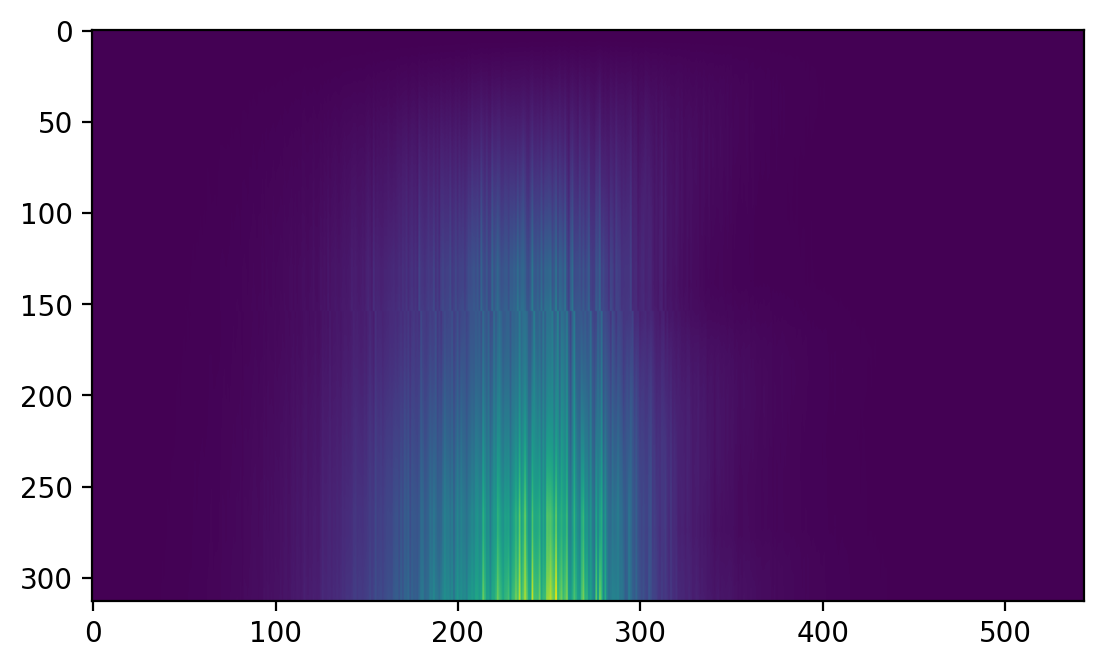

In [27]:
plt.imshow(G.output['Field/power'])

# Future work

In [28]:
from dataclasses import dataclass

@dataclass(frozen=True)
class Setup:
    rootname: str = None
    lattice: str = None
    beamline: str = None
    gamma0: float = 11350.3
    lambda0: float = 1e-10
    delz: float = 0.015
    seed: int = 123456789
    npart: int = 8192
    nbins: int = 4
    one4one: bool = False
    shotnoise: bool = True
    beam_global_stat: bool = False
    field_global_stat: bool = False
    exclude_spatial_output: bool = False
    exclude_fft_output: bool = False
    exclude_intensity_output: bool = False
    exclude_energy_output: bool = False
    exclude_aux_output: bool = False
    exclude_current_output: bool = True

In [29]:
dat = {
    'type':'setup',
   'rootname': 'LCLS2_HXR_9keV',
   'lattice': '/Users/chrisonian/Code/GitHub/lume-genesis/examples/data/basic4/hxr.lat',
   'beamline': 'HXR',
   'lambda0': 1.3789244869952112e-10,
   'gamma0': 19174.0776,
   'delz': 0.026,
   'seed': 84672,
   'npart': 1024}

lookup = {'setup':Setup}

def make(dat):
    type = dat.pop('type')
    return lookup[type](**dat)
s = make(dat)
s

Setup(rootname='LCLS2_HXR_9keV', lattice='/Users/chrisonian/Code/GitHub/lume-genesis/examples/data/basic4/hxr.lat', beamline='HXR', gamma0=19174.0776, lambda0=1.3789244869952112e-10, delz=0.026, seed=84672, npart=1024, nbins=4, one4one=False, shotnoise=True, beam_global_stat=False, field_global_stat=False, exclude_spatial_output=False, exclude_fft_output=False, exclude_intensity_output=False, exclude_energy_output=False, exclude_aux_output=False, exclude_current_output=True)

In [30]:
s0 = Setup()

In [31]:
from dataclasses import asdict
d2 = asdict(s0)
for k in list(d2):
    if getattr(s, k) == d2[k]:
        d2.pop(k)
d2

{'rootname': None,
 'lattice': None,
 'beamline': None,
 'gamma0': 11350.3,
 'lambda0': 1e-10,
 'delz': 0.015,
 'seed': 123456789,
 'npart': 8192}